# Antarctic SMB trends

Author: Ziqi Yin

Last edited: Jul 29, 2025

## Description

SMB trends:
- Simulation: CESM2-LE, CESM2-LE*, CESM2-TPACE, MT19
- Method: epoch difference of 1976:2000 minus 1901:1925

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.path as mpath
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [ ]:
%pip install cmaps

In [2]:
# https://github.com/hhuangwx/cmaps
import cmaps

In [3]:
def calculate_AIS_SMB(path, fn_p1, yr_s, yr_e):

    ## Read data
    fn_RAIN = fn_p1+'.RAIN.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    RAIN = xr.open_dataset(path+fn_RAIN).RAIN
    fn_SNOW = fn_p1+'.SNOW.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    SNOW = xr.open_dataset(path+fn_SNOW).SNOW
    fn_QSOIL = fn_p1+'.QSOIL.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    QSOIL = xr.open_dataset(path+fn_QSOIL).QSOIL
    fn_QRUNOFF = fn_p1+'.QRUNOFF.'+str(yr_s)+'01-'+str(yr_e)+'12.nc'
    QRUNOFF = xr.open_dataset(path+fn_QRUNOFF).QRUNOFF
    SMB = RAIN + SNOW - QSOIL - QRUNOFF

    ## Correct time
    dates = pd.date_range(str(yr_s)+'-01-01', periods=(yr_e-yr_s+1)*12, freq='M')
    SMB['time'] = dates

    # Plot period (currently same to the whole period)
    SMB_monthly = SMB.sel(time=slice(str(yr_s)+'-01-01', str(yr_e)+'-12-31')) #[mm/s]
    SMB_yearly = (SMB_monthly * GROUNDEDMASK.values * SMB_monthly.time.dt.days_in_month * (24*3600)).groupby(SMB_monthly.time.dt.year).sum() #[mm/yr]

    return SMB_yearly

## Read data

### Ensemble mean

In [6]:
xr.open_dataset('/glade/work/dschneid/zaria_snow/merra_medley_regrid.nc').smb.sel(lon=180).sel(year=1923).values
# Found that the regridded MT19 misses six grid points at longitude 180

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [5]:
## SMB variables
# MT19 (1801-2000)
path = '/glade/work/dschneid/zaria_snow/'

fn_SMB_MT = 'merra_medley_regrid.nc'
SMB_MT = xr.open_dataset(path+fn_SMB_MT).smb
lat_MT = np.array(SMB_MT.lat)
lon_MT = np.array(SMB_MT.lon)

# CESM2-LE (50 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/'

fn_RAIN_LE = 'b.e21.BHISTsmbb.f09_g17.LE2.EM1-50.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE = xr.open_dataset(path+fn_RAIN_LE).RAIN #[mm/s]
fn_SNOW_LE = 'b.e21.BHISTsmbb.f09_g17.LE2.EM1-50.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE = xr.open_dataset(path+fn_SNOW_LE).SNOW
fn_QSOIL_LE = 'b.e21.BHISTsmbb.f09_g17.LE2.EM1-50.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE = xr.open_dataset(path+fn_QSOIL_LE).QSOIL
fn_QRUNOFF_LE = 'b.e21.BHISTsmbb.f09_g17.LE2.EM1-50.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE = xr.open_dataset(path+fn_QRUNOFF_LE).QRUNOFF
SMB_LE = RAIN_LE + SNOW_LE - QSOIL_LE - QRUNOFF_LE
lat = np.array(RAIN_LE.lat)
lon = np.array(RAIN_LE.lon)

# CESM2-LE (10 members, 1850-2100, to compare with TPACE)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/TPACE_subset/'

fn_RAIN_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE10 = xr.open_dataset(path+fn_RAIN_LE10).RAIN #[mm/s]
fn_SNOW_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE10 = xr.open_dataset(path+fn_SNOW_LE10).SNOW
fn_QSOIL_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE10 = xr.open_dataset(path+fn_QSOIL_LE10).QSOIL
fn_QRUNOFF_LE10 = 'b.e21.BHISTcmip6.f09_g17.LE2-EM1-10.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE10 = xr.open_dataset(path+fn_QRUNOFF_LE10).QRUNOFF
SMB_LE10 = RAIN_LE10 + SNOW_LE10 - QSOIL_LE10 - QRUNOFF_LE10

# CESM2-TPACE (10 members, 1880-2019)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'

fn_RAIN_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.RAIN.188001-201912.nc'
RAIN_TPACE = xr.open_dataset(path+fn_RAIN_TPACE).RAIN
fn_SNOW_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.SNOW.188001-201912.nc'
SNOW_TPACE = xr.open_dataset(path+fn_SNOW_TPACE).SNOW
fn_QSOIL_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QSOIL.188001-201912.nc'
QSOIL_TPACE = xr.open_dataset(path+fn_QSOIL_TPACE).QSOIL
fn_QRUNOFF_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QRUNOFF.188001-201912.nc'
QRUNOFF_TPACE = xr.open_dataset(path+fn_QRUNOFF_TPACE).QRUNOFF
SMB_TPACE = RAIN_TPACE + SNOW_TPACE - QSOIL_TPACE - QRUNOFF_TPACE

In [7]:
## Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

# Select lat range
GROUNDEDMASK_sel = GROUNDEDMASK.sel(lat=slice(-90,-60))

# Rearrange the longitude for CESM2, from [0~360] to [-180~180]
GROUNDEDMASK_sel_lon_new = GROUNDEDMASK_sel.lon.where(GROUNDEDMASK_sel.lon<=180, GROUNDEDMASK_sel.lon-360)
GROUNDEDMASK_sel['lon'] = GROUNDEDMASK_sel_lon_new
GROUNDEDMASK_sel_rearrange = GROUNDEDMASK_sel.sortby(GROUNDEDMASK_sel.lon)
# Note: in the calculation below, GROUNDEDMASK_sel_rearrange also needs to be add with ".values" since its lat values are not exactly the same to those in SMB_MT

In [8]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
SMB_LE['time'] = dates
SMB_LE10['time'] = dates

dates = pd.date_range("1880-01-01", periods=140*12, freq='M')
SMB_TPACE['time'] = dates

/glade/derecho/scratch/ziqiyin/tmp/ipykernel_106780/1794060663.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1850-01-01", periods=251*12, freq='M')
/glade/derecho/scratch/ziqiyin/tmp/ipykernel_106780/1794060663.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("1880-01-01", periods=140*12, freq='M')


In [9]:
## Select time period
SMB_LE = SMB_LE.sel(time=slice("1901-01-01", "2000-12-31"))
SMB_LE10 = SMB_LE10.sel(time=slice("1901-01-01", "2000-12-31"))

### Ensembles

In [ ]:
# CESM2-LE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/'
yr_s = 1850
yr_e = 2100
SMB_LE_yearly = np.zeros((50, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['1011.001', '1031.002', '1051.003', '1071.004', '1091.005', '1111.006', '1131.007', '1151.008', '1171.009', '1191.010',
      '1231.011', '1231.012', '1231.013', '1231.014', '1231.015', '1231.016', '1231.017', '1231.018', '1231.019', '1231.020',
      '1251.011', '1251.012', '1251.013', '1251.014', '1251.015', '1251.016', '1251.017', '1251.018', '1251.019', '1251.020',
      '1281.011', '1281.012', '1281.013', '1281.014', '1281.015', '1281.016', '1281.017', '1281.018', '1281.019', '1281.020',
      '1301.011', '1301.012', '1301.013', '1301.014', '1301.015', '1301.016', '1301.017', '1301.018', '1301.019', '1301.020']

for i in range(50):
    fn_p1 = 'b.e21.BHISTsmbb.f09_g17.LE2-'+mn[i]+'.clm2.h0'
    SMB_LE_yearly[i,:,:,:] = calculate_AIS_SMB(path, fn_p1, yr_s, yr_e)

In [25]:
# Save as netcdf file
df = xr.DataArray(SMB_LE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,51)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='SMB', attrs=dict(longname='annual SMB over the grounded AIS', units='mm/yr'))
df.to_netcdf('SMB_LE_ensemble_yearly.nc')

In [11]:
SMB_LE_ensemble_yearly = xr.open_dataset('../../SMB_LE_ensemble_yearly.nc').SMB

In [31]:
# CESM2-TPACE
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'
yr_s = 1880
yr_e = 2019
SMB_TPACE_yearly = np.zeros((10, yr_e-yr_s+1, len(lat), len(lon)))

for i in range(10):
    fn_p1 = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.'+'{:03d}'.format(i+1)+'.clm2.h0'
    SMB_TPACE_yearly[i,:,:,:] = calculate_AIS_SMB(path, fn_p1, yr_s, yr_e)

In [32]:
# Save as netcdf file
df = xr.DataArray(SMB_TPACE_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,11)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='SMB', attrs=dict(longname='annual SMB over the grounded AIS', units='mm/yr'))
df.to_netcdf('SMB_TPACE_ensemble_yearly.nc')

In [12]:
SMB_TPACE_ensemble_yearly = xr.open_dataset('../../SMB_TPACE_ensemble_yearly.nc').SMB

In [9]:
# CESM2-LE*
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/TPACE_subset/'
yr_s = 1850
yr_e = 2100
SMB_LE10_yearly = np.zeros((10, yr_e-yr_s+1, len(lat), len(lon)))
mn = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010']

for i in range(10):
    fn_p1 = 'b.e21.BHISTcmip6.f09_g17.LE2-'+mn[i]+'.clm2.h0'
    SMB_LE10_yearly[i,:,:,:] = calculate_AIS_SMB(path, fn_p1, yr_s, yr_e)

In [10]:
# Save as netcdf file
df = xr.DataArray(SMB_LE10_yearly, dims=['num', 'year', 'lat', 'lon'], coords=[('num', np.arange(1,11)), ('year', np.arange(yr_s,yr_e+1)), ('lat', lat), ('lon', lon)], name='SMB', attrs=dict(longname='annual SMB over the grounded AIS', units='mm/yr'))
df.to_netcdf('SMB_LE10_ensemble_yearly.nc')

In [13]:
SMB_LE10_ensemble_yearly = xr.open_dataset('../../SMB_LE10_ensemble_yearly.nc').SMB

## Calculate

### Ensemble mean

In [14]:
## Calculate yearly mean SMB over the grounded ice sheet
days_in_month = SMB_LE.time.dt.days_in_month
year = SMB_LE.time.dt.year
SMB_LE_monthly = SMB_LE #[mm/s]
SMB_LE_yearly = (SMB_LE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

SMB_LE10_monthly = SMB_LE10 #[mm/s]
SMB_LE10_yearly = (SMB_LE10_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

SMB_TPACE_monthly = SMB_TPACE #[mm/s]
SMB_TPACE_yearly = (SMB_TPACE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

SMB_MT_yearly = SMB_MT * GROUNDEDMASK_sel_rearrange.values

In [15]:
## Calculate trend using epoch difference
SMB_LE_trend = (SMB_LE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - SMB_LE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]
SMB_LE10_trend = (SMB_LE10_yearly.sel(year=slice('1976','2000')).mean(dim='year') - SMB_LE10_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]
SMB_TPACE_trend = (SMB_TPACE_yearly.sel(year=slice('1976','2000')).mean(dim='year') - SMB_TPACE_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]
SMB_MT_trend = (SMB_MT_yearly.sel(year=slice('1976','2000')).mean(dim='year') - SMB_MT_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]

# Set back nan values
SMB_LE_trend = np.where(SMB_LE_trend != 0, SMB_LE_trend, np.NaN)
SMB_LE10_trend = np.where(SMB_LE10_trend != 0, SMB_LE10_trend, np.NaN)
SMB_TPACE_trend = np.where(SMB_TPACE_trend != 0, SMB_TPACE_trend, np.NaN)
#SMB_MT_trend = np.where(SMB_MT_trend != 0, SMB_MT_trend, np.NaN)

In [16]:
## Add cyclic points
SMB_LE_trend_full, lon_full = add_cyclic_point(SMB_LE_trend, coord=lon)
SMB_LE10_trend_full, lon_full = add_cyclic_point(SMB_LE10_trend, coord=lon)
SMB_TPACE_trend_full, lon_full = add_cyclic_point(SMB_TPACE_trend, coord=lon)
SMB_MT_trend_full, lon_MT_full = add_cyclic_point(SMB_MT_trend, coord=lon_MT)

# Set back nan values
#SMB_LE_trend_full = np.where(SMB_LE_trend_full != 0, SMB_LE_trend_full, np.NaN)
#SMB_LE10_trend_full = np.where(SMB_LE10_trend_full != 0, SMB_LE10_trend_full, np.NaN)
#SMB_TPACE_trend_full = np.where(SMB_TPACE_trend_full != 0, SMB_TPACE_trend_full, np.NaN)
#SMB_MT_trend_full = np.where(SMB_MT_trend_full != 0, SMB_MT_trend_full, np.NaN)

In [17]:
# (Check) TPACE - LE*
SMB_TPACE_LE10_ensemble_yearly = SMB_TPACE_ensemble_yearly.sel(year=(slice(1901, 2000))) - SMB_LE10_ensemble_yearly.sel(year=(slice(1901, 2000)))
SMB_TPACE_LE10_yearly = SMB_TPACE_LE10_ensemble_yearly.mean(dim='num')
SMB_TPACE_LE10_trend = (SMB_TPACE_LE10_yearly.sel(year=slice('1976','2000')).mean(dim='year') - SMB_TPACE_LE10_yearly.sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]
SMB_TPACE_LE10_trend = np.where(SMB_TPACE_LE10_trend != 0, SMB_TPACE_LE10_trend, np.NaN)

### Ensembles

In [18]:
# CESM2-LE
SMB_LE_ensemble_trend = np.zeros((50,len(lat),len(lon)))
SMB_LE_ensemble_trend_full = np.zeros((50,len(lat),len(lon)+1))

for i in range(50):
    # Calculate trend using epoch difference
    SMB_LE_ensemble_trend[i,:,:] = (SMB_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - SMB_LE_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]

    # Add cyclic points
    SMB_LE_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(SMB_LE_ensemble_trend[i,:,:], coord=lon)

    # Set back zero
    SMB_LE_ensemble_trend[i,:,:] = np.where(SMB_LE_ensemble_trend[i,:,:] != 0, SMB_LE_ensemble_trend[i,:,:], np.NaN)
    SMB_LE_ensemble_trend_full[i,:,:] = np.where(SMB_LE_ensemble_trend_full[i,:,:] != 0, SMB_LE_ensemble_trend_full[i,:,:], np.NaN)

In [19]:
# CESM2-TPACE
SMB_TPACE_ensemble_trend = np.zeros((10,len(lat),len(lon)))
SMB_TPACE_ensemble_trend_full = np.zeros((10,len(lat),len(lon)+1))

for i in range(10):
    # Calculate trend using epoch difference
    SMB_TPACE_ensemble_trend[i,:,:] = (SMB_TPACE_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - SMB_TPACE_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]

    # Add cyclic points
    SMB_TPACE_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(SMB_TPACE_ensemble_trend[i,:,:], coord=lon)

    # Set back zero
    SMB_TPACE_ensemble_trend[i,:,:] = np.where(SMB_TPACE_ensemble_trend[i,:,:] != 0, SMB_TPACE_ensemble_trend[i,:,:], np.NaN)
    SMB_TPACE_ensemble_trend_full[i,:,:] = np.where(SMB_TPACE_ensemble_trend_full[i,:,:] != 0, SMB_TPACE_ensemble_trend_full[i,:,:], np.NaN)

In [20]:
# CESM2-LE*
SMB_LE10_ensemble_trend = np.zeros((10,len(lat),len(lon)))
SMB_LE10_ensemble_trend_full = np.zeros((10,len(lat),len(lon)+1))

for i in range(10):
    # Calculate trend using epoch difference
    SMB_LE10_ensemble_trend[i,:,:] = (SMB_LE10_ensemble_yearly.sel(num=i+1).sel(year=slice('1976','2000')).mean(dim='year') - SMB_LE10_ensemble_yearly.sel(num=i+1).sel(year=slice('1901','1925')).mean(dim='year')) / 75 #[mm/yr2]

    # Add cyclic points
    SMB_LE10_ensemble_trend_full[i,:,:], lon_full = add_cyclic_point(SMB_LE10_ensemble_trend[i,:,:], coord=lon)

    # Set back zero
    SMB_LE10_ensemble_trend[i,:,:] = np.where(SMB_LE10_ensemble_trend[i,:,:] != 0, SMB_LE10_ensemble_trend[i,:,:], np.NaN)
    SMB_LE10_ensemble_trend_full[i,:,:] = np.where(SMB_LE10_ensemble_trend_full[i,:,:] != 0, SMB_LE10_ensemble_trend_full[i,:,:], np.NaN)

## Correlation with reanalysis

In [21]:
# Change lon range from [-180, 180] to [0, 360] and sort along lon axis
SMB_MT_trend_new = SMB_MT_trend.copy()
lon_MT_new = lon_MT.copy()
lon_MT_new = lon_MT_new % 360
SMB_MT_trend_new['lon'] = lon_MT_new

SMB_MT_trend_newsort = SMB_MT_trend_new.sortby(SMB_MT_trend_new['lon'])

In [22]:
# MT19
SMB_MT_trend_flat = SMB_MT_trend_newsort.values.flatten()
SMB_MT_trend_flat_nonan = SMB_MT_trend_flat[~np.isnan(SMB_MT_trend_flat)]

In [23]:
# CESM2-LE ensemble mean
SMB_LE_trend_no180E = xr.where(lon==180, np.NaN, SMB_LE_trend) # Remove the 6 grids at lon 180 that MT19 doesn't have
SMB_LE_trend_flat = SMB_LE_trend_no180E.flatten()
SMB_LE_trend_flat_nonan = SMB_LE_trend_flat[~np.isnan(SMB_LE_trend_flat)]
SMB_LE_trend_cor, _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_LE_trend_flat_nonan)

In [24]:
# CESM2-LE* ensemble mean
SMB_LE10_trend_no180E = xr.where(lon==180, np.NaN, SMB_LE10_trend) # Remove the 6 grids at lon 180 that MT19 doesn't have
SMB_LE10_trend_flat = SMB_LE10_trend_no180E.flatten()
SMB_LE10_trend_flat_nonan = SMB_LE10_trend_flat[~np.isnan(SMB_LE10_trend_flat)]
SMB_LE10_trend_cor, _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_LE10_trend_flat_nonan)

In [25]:
# CESM2-TPACE ensemble mean
SMB_TPACE_trend_no180E = xr.where(lon==180, np.NaN, SMB_TPACE_trend) # Remove the 6 grids at lon 180 that MT19 doesn't have
SMB_TPACE_trend_flat = SMB_TPACE_trend_no180E.flatten()
SMB_TPACE_trend_flat_nonan = SMB_TPACE_trend_flat[~np.isnan(SMB_TPACE_trend_flat)]
SMB_TPACE_trend_cor, _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_TPACE_trend_flat_nonan)

In [26]:
# (Check) CESM2-TPACE - CESM2-LE* ensemble mean
SMB_TPACE_LE10_trend_no180E = xr.where(lon==180, np.NaN, SMB_TPACE_LE10_trend) # Remove the 6 grids at lon 180 that MT19 doesn't have
SMB_TPACE_LE10_trend_flat = SMB_TPACE_LE10_trend_no180E.flatten()
SMB_TPACE_LE10_trend_flat_nonan = SMB_TPACE_LE10_trend_flat[~np.isnan(SMB_TPACE_LE10_trend_flat)]
SMB_TPACE_LE10_trend_cor, _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_TPACE_LE10_trend_flat_nonan)
print(SMB_TPACE_LE10_trend_cor)

-0.6350667405409258


In [27]:
# CESM2-LE ensemble members
SMB_LE_ensemble_trend_cor = np.zeros(50)

for i in range(50):
    SMB_LE_ensemble_trend_no180E = xr.where(lon==180, np.NaN, SMB_LE_ensemble_trend[i,:,:])
    SMB_LE_ensemble_trend_flat = SMB_LE_ensemble_trend_no180E.flatten()
    SMB_LE_ensemble_trend_flat_nonan = SMB_LE_ensemble_trend_flat[~np.isnan(SMB_LE_ensemble_trend_flat)]
    SMB_LE_ensemble_trend_cor[i], _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_LE_ensemble_trend_flat_nonan)

In [28]:
# CESM2-TPACE ensemble members
SMB_TPACE_ensemble_trend_cor = np.zeros(10)

for i in range(10):
    SMB_TPACE_ensemble_trend_no180E = xr.where(lon==180, np.NaN, SMB_TPACE_ensemble_trend[i,:,:])
    SMB_TPACE_ensemble_trend_flat = SMB_TPACE_ensemble_trend_no180E.flatten()
    SMB_TPACE_ensemble_trend_flat_nonan = SMB_TPACE_ensemble_trend_flat[~np.isnan(SMB_TPACE_ensemble_trend_flat)]
    SMB_TPACE_ensemble_trend_cor[i], _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_TPACE_ensemble_trend_flat_nonan)

In [29]:
# CESM2-LE* ensemble members
SMB_LE10_ensemble_trend_cor = np.zeros(10)

for i in range(10):
    SMB_LE10_ensemble_trend_no180E = xr.where(lon==180, np.NaN, SMB_LE10_ensemble_trend[i,:,:])
    SMB_LE10_ensemble_trend_flat = SMB_LE10_ensemble_trend_no180E.flatten()
    SMB_LE10_ensemble_trend_flat_nonan = SMB_LE10_ensemble_trend_flat[~np.isnan(SMB_LE10_ensemble_trend_flat)]
    SMB_LE10_ensemble_trend_cor[i], _ = pearsonr(SMB_MT_trend_flat_nonan, SMB_LE10_ensemble_trend_flat_nonan)

## Plot

### Ensemble mean

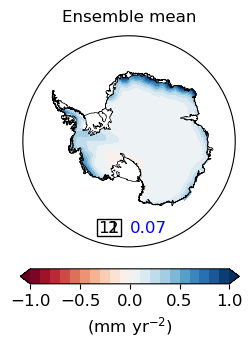

In [79]:
fig=plt.figure(figsize=(3,3))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad']=14

level_SMB = np.arange(-1, 1.1, 0.1)
ticks_SMB = np.arange(-1, 1.1, 0.5)

size_title = 12
size_label = 12
size_tick = 12
size_text = 12

cmap1='RdBu'

######################### Esemble mean #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1=ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

# example: draw circle with 45 degree radius around the North pole
lat2 = -90
lon2 = 0
r = 30

# Define the projection used to display the circle:
proj = ccrs.SouthPolarStereo(central_longitude=lon2)


def compute_radius(ortho, radius_degrees):
    phi1 = lat2 + radius_degrees if lat2 <= 0 else lat2 - radius_degrees
    _, y1 = ortho.transform_point(lon2, phi1, ccrs.PlateCarree())
    return abs(y1)

# Compute the required radius in projection native coordinates:
r_ortho = compute_radius(proj, r)

# We can now compute the correct plot extents to have padding in degrees:
pad_radius = compute_radius(proj, r + 5)

projx1, projy1 = proj.transform_point(lon2, lat2, ccrs.Geodetic()) #get proj coord of (lon,lat)

#ax1.add_patch(mpatches.Circle(xy=[projx1, projy1], radius=r_ortho, ec='black', lw=2, fill=False, transform=proj, zorder=30))
ax1.set_title('Ensemble mean', pad=12, fontsize=size_title)

ax1.text(-1000000, -3000000, '11', fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
ax1.text(-680000, -3000000, '2', fontsize=size_text)
ax1.text(30000, -3000000, '0.07', fontsize=size_text, color='b')

#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.05]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('(mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.07,
                    hspace=0.09)

plt.subplots_adjust(bottom=0.19)
#plt.savefig('map_AIS_SMB_trend_CESM2-LE_epoch.jpg',dpi=300)
plt.show()

### Ensembles

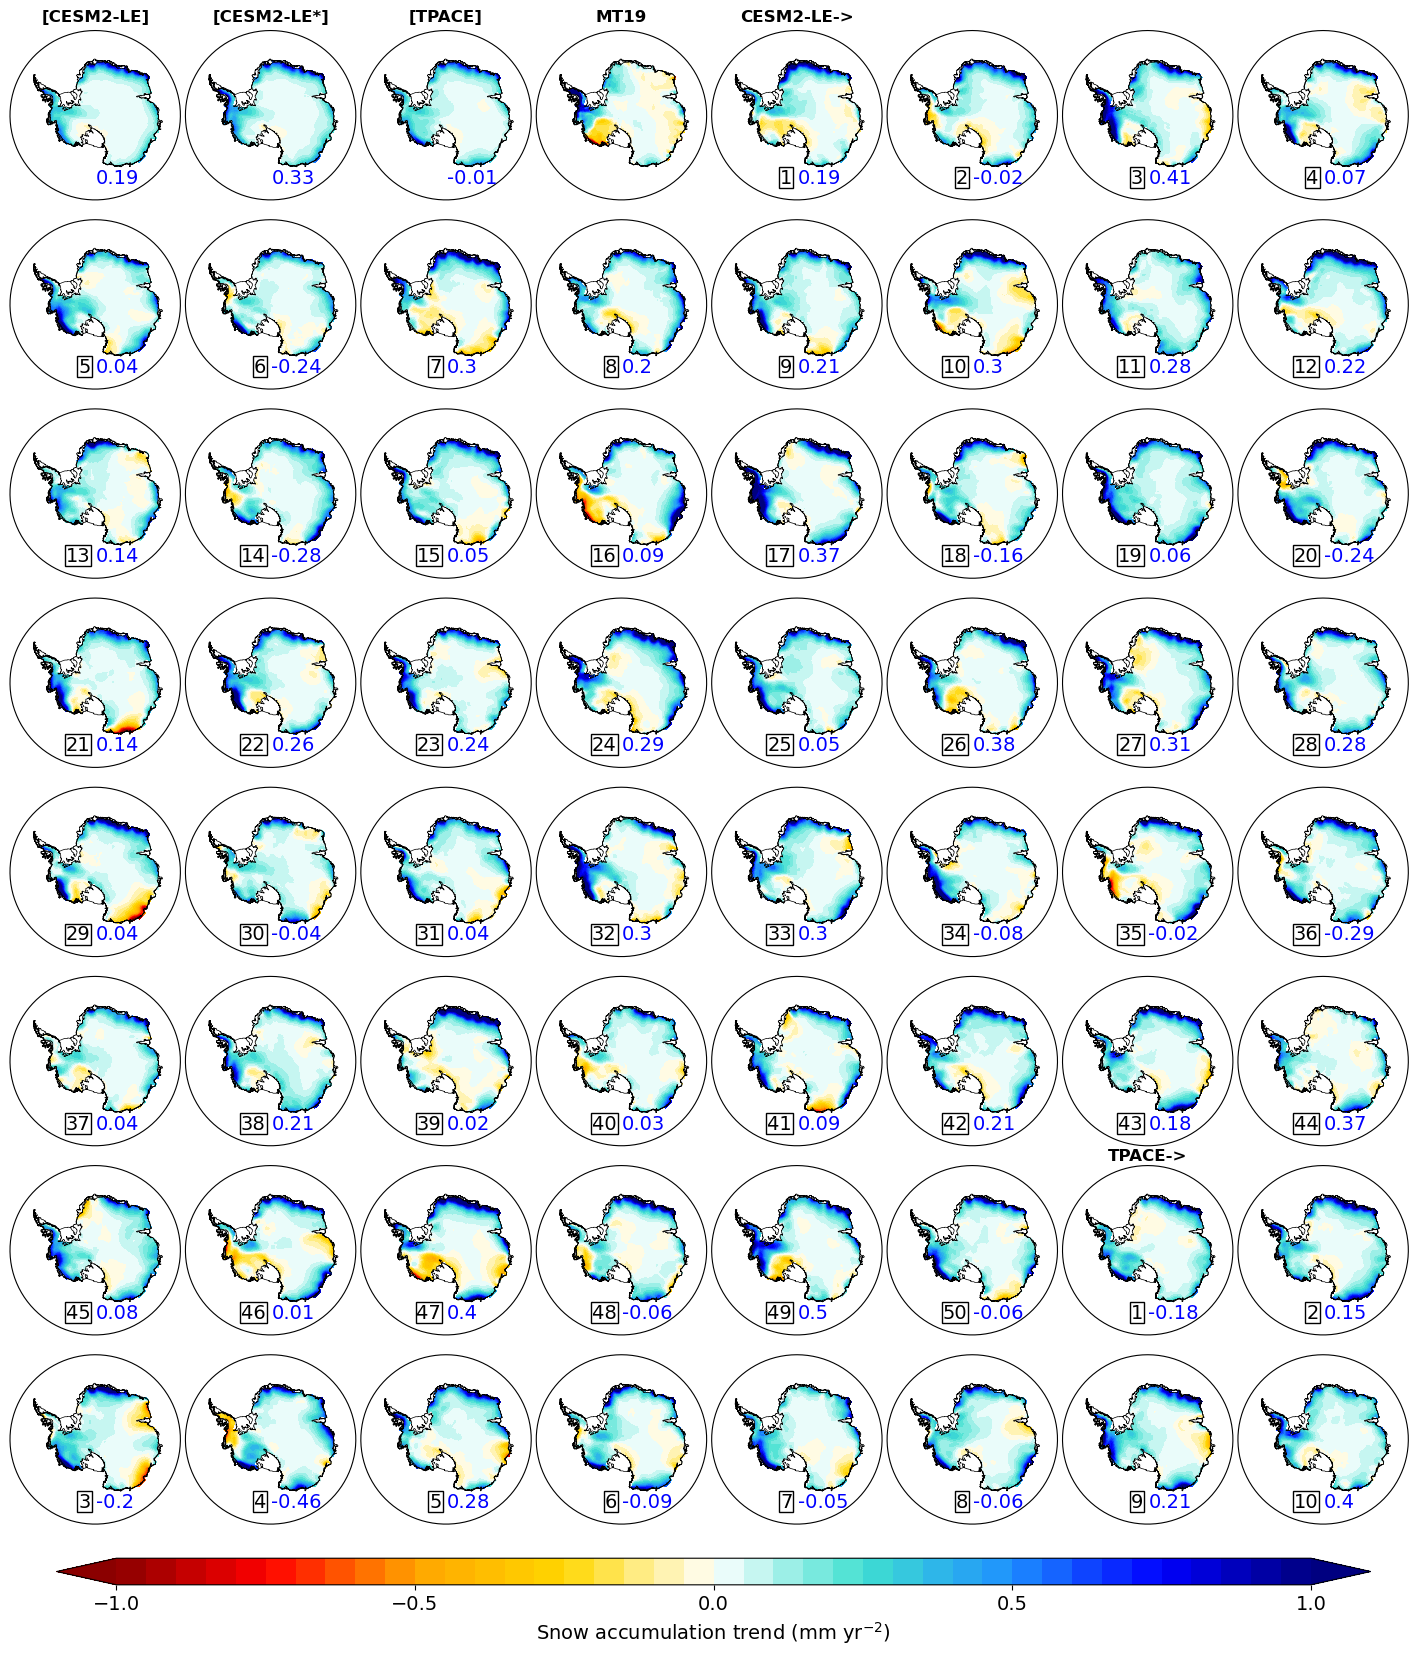

In [30]:
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_SMB = np.arange(-1, 1.01, 0.05)
ticks_SMB = np.arange(-1, 1.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

#cmap1='RdBu'
cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])

######################### Esemble mean #########################
# CESM2-LE 50 members
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1=ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax1.set_title('[CESM2-LE]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(30000, -2800000, round(SMB_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2=ax2.contourf(lon_full, lat, SMB_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax2.set_title('[CESM2-LE*]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(30000, -2800000, round(SMB_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3=ax3.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax3.set_title('[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(30000, -2800000, round(SMB_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# MT19
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4=ax4.contourf(lon_MT_full, lat_MT, SMB_MT_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax4.set_title('MT19', pad=8, fontsize=size_title, fontweight='bold')

######################### Esemble members #########################
# CESM2-LE
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title, fontweight='bold')
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1200000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -2800000, round(SMB_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('TPACE->', pad=5, fontsize=size_title, fontweight='bold')
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1200000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -2800000, round(SMB_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig(
    '../plot/C1_map_AIS_SMB_trend_CESM2-LE_TPACE_ensemble_MT19_epoch_2501.jpg',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)
plt.show()

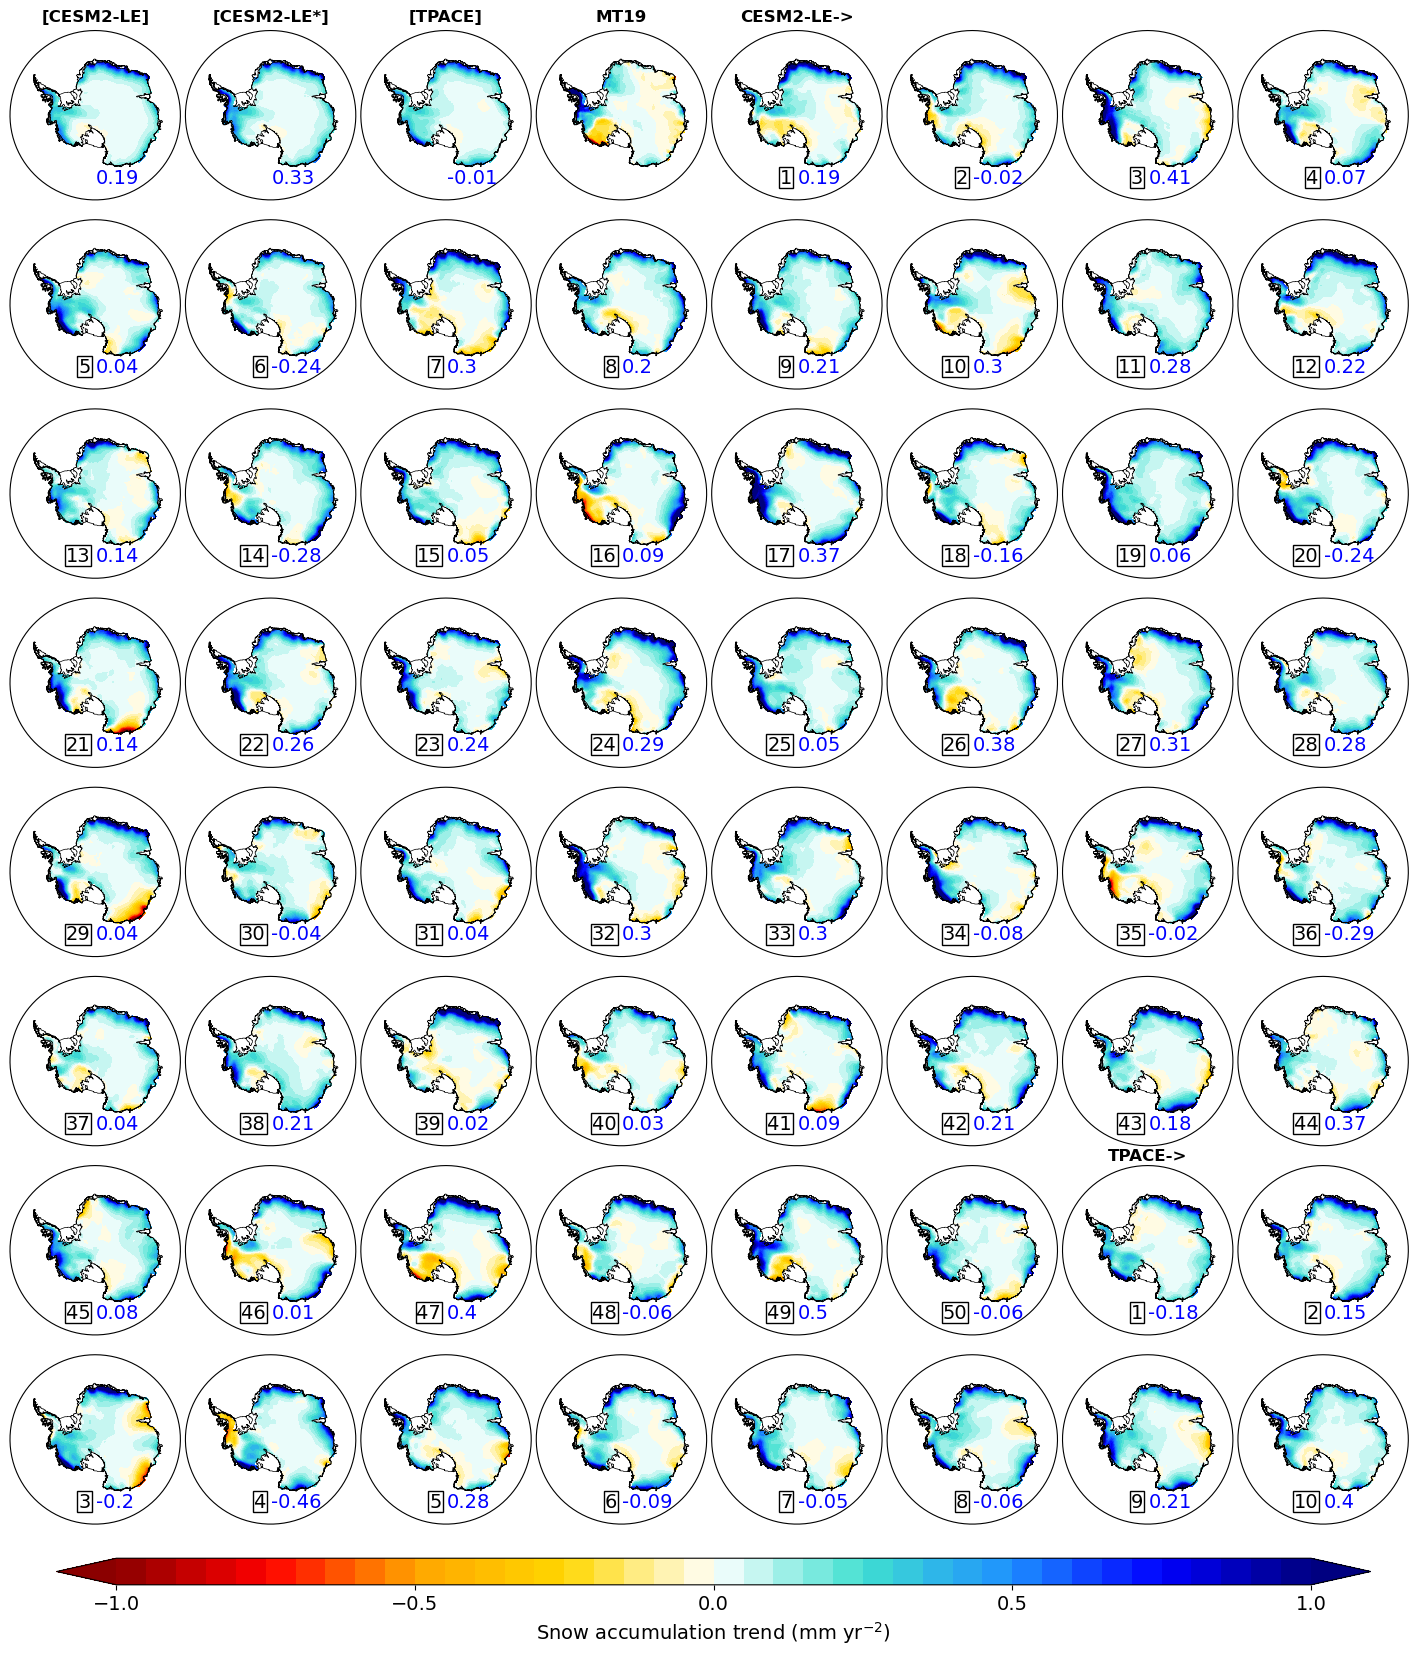

In [31]:
# Save as pdf format
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_SMB = np.arange(-1, 1.01, 0.05)
ticks_SMB = np.arange(-1, 1.01, 0.5)

size_title = 10+2
size_label = 12+2
size_tick = 12+2
size_text = 12+2

#cmap1='RdBu'
cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])

######################### Esemble mean #########################
# CESM2-LE 50 members
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1=ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax1.set_title('[CESM2-LE]', pad=8, fontsize=size_title, fontweight='bold')
ax1.text(30000, -2800000, round(SMB_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2=ax2.contourf(lon_full, lat, SMB_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax2.set_title('[CESM2-LE*]', pad=8, fontsize=size_title, fontweight='bold')
ax2.text(30000, -2800000, round(SMB_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3=ax3.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax3.set_title('[TPACE]', pad=8, fontsize=size_title, fontweight='bold')
ax3.text(30000, -2800000, round(SMB_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# MT19
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4=ax4.contourf(lon_MT_full, lat_MT, SMB_MT_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax4.set_title('MT19', pad=8, fontsize=size_title, fontweight='bold')

######################### Esemble members #########################
# CESM2-LE
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title, fontweight='bold')
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1200000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -2800000, round(SMB_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

# CESM2-TPACE
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_TPACE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('TPACE->', pad=5, fontsize=size_title, fontweight='bold')
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1200000, -2800000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -2800000, round(SMB_TPACE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig(
    '../plot/C1_map_AIS_SMB_trend_CESM2-LE_TPACE_ensemble_MT19_epoch_2501.pdf',
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

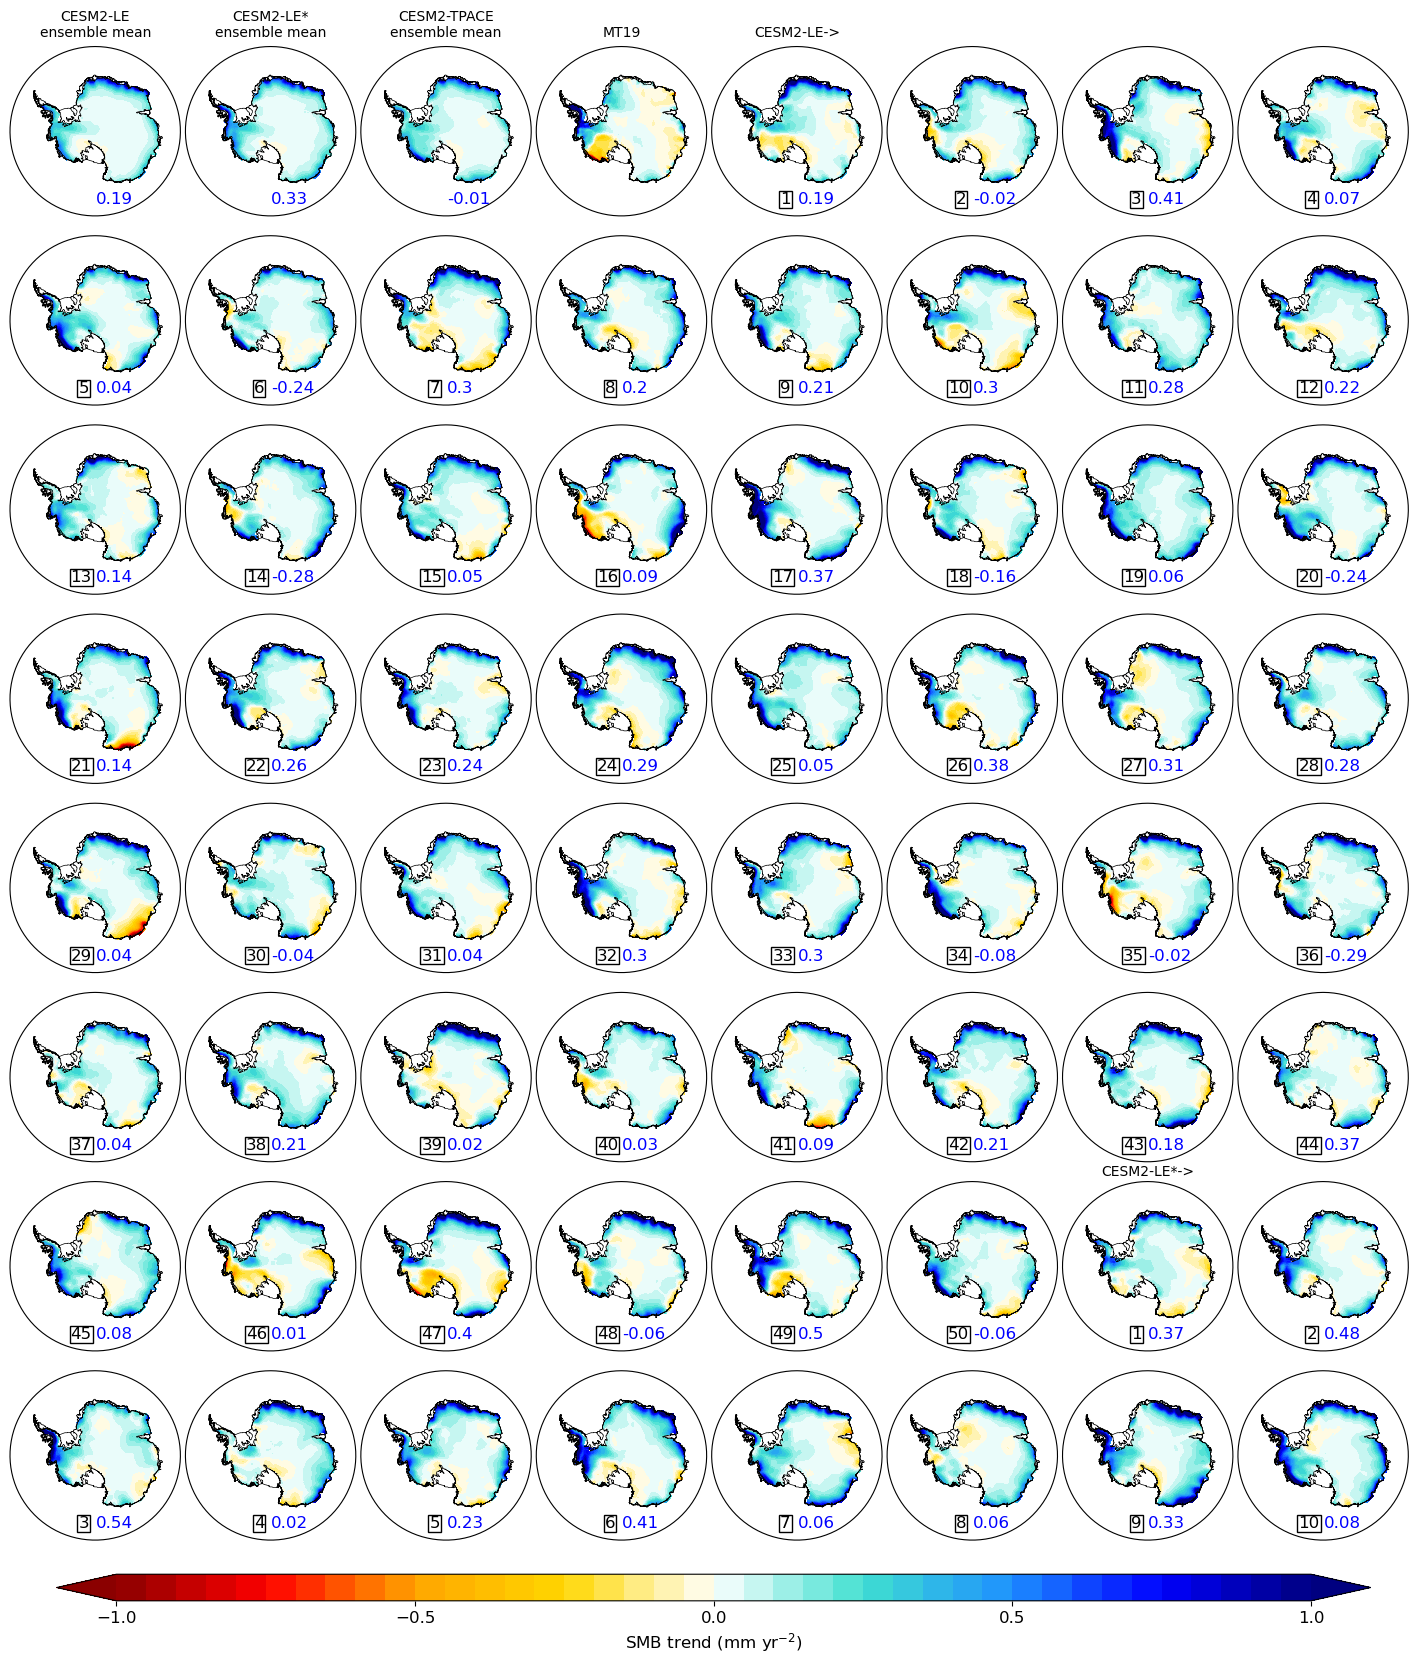

In [27]:
## LE10 ensemble members replacing TPACE ensemble members
fig=plt.figure(figsize=(18,19))
gs=GridSpec(8,8)
plt.rcParams['axes.titlepad']=14

level_SMB = np.arange(-1, 1.01, 0.05)
ticks_SMB = np.arange(-1, 1.01, 0.5)

size_title = 10
size_label = 12
size_tick = 12
size_text = 12

#cmap1='RdBu'
cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])

######################### Esemble mean #########################
# CESM2-LE 50 members
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1=ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax1.set_title('CESM2-LE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax1.text(30000, -3000000, round(SMB_LE_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-LE 10 members
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2=ax2.contourf(lon_full, lat, SMB_LE10_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax2.set_title('CESM2-LE*\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax2.text(30000, -3000000, round(SMB_LE10_trend_cor, 2), fontsize=size_text, color='b')

# CESM2-TPACE
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3=ax3.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax3.set_title('CESM2-TPACE\n'
              'ensemble mean', pad=8, fontsize=size_title)
ax3.text(30000, -3000000, round(SMB_TPACE_trend_cor, 2), fontsize=size_text, color='b')

# MT19
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4=ax4.contourf(lon_MT_full, lat_MT, SMB_MT_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')
ax4.set_title('MT19', pad=8, fontsize=size_title)

######################### Esemble members #########################
# CESM2-LE
for i in range(50):
    ax = plt.subplot(gs[i+4], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_LE_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE->', pad=8, fontsize=size_title)
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -3000000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1000000, -3000000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -3000000, round(SMB_LE_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

# CESM2-LE10
for i in range(10):
    ax = plt.subplot(gs[i+54], projection=ccrs.SouthPolarStereo())
    plot_antarctica(ax, -60)

    im=ax.contourf(lon_full, lat, SMB_LE10_ensemble_trend_full[i,:,:], cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

    if i < 9:
        if i == 0:
            ax.set_title('CESM2-LE*->', pad=5, fontsize=size_title)
        #ax.text(-120000, -3000000, str(i+1), fontsize=size_text)
        ax.text(-680000, -3000000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))
    else:
        ax.text(-1000000, -3000000, str(i+1), fontsize=size_text, bbox=dict(facecolor='none', edgecolor='k', pad=0.7))

    ax.text(30000, -3000000, round(SMB_LE10_ensemble_trend_cor[i], 2), fontsize=size_text, color='b')

#Colorbar
cbar_ax = fig.add_axes([0.15, 0.06, 0.73, 0.014]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SMB trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.05,
                    hspace=0.07)

plt.subplots_adjust(bottom=0.09)
plt.savefig('map_AIS_SMB_trend_CESM2-LE_LE10_ensemble_MT19_epoch_v2.jpg',dpi=300)
plt.show()